# Bioreactor Monitoring

In [116]:
# mrr.RX_SHIFT = 5000

def ncpmg(f0 = None, t90 = None, gain=70, tr=3e-3, npulses = 100, cycle=[0,0,1,3], width=1000, p90p = 0, raw=False):
    if f0 is None:
        f0 = mrr.caldict["f0"]
    if t90 is None:
        t90 = mrr.caldict["t90"]

    t180 = 2*t90

    ############################## Internal Helpers ##########################
    def _pulse(start_time, firstpulse, phase):

        #Sequencing variables
        tx_start_time = start_time - mrr.ZBUFF_TIME
        sw_on_time = start_time - 5e-6
        sw_off_time = start_time + mrr.DEAD_TIME + (t90 if firstpulse else 2*t90)
        tx_metadata.time_spec = lib.types.time_spec(tx_start_time)
        
        #Create the pulses    
        zero_buff = np.zeros(int(mrr.ZBUFF_TIME * mrr.FS))
        t90_base = 0.9*np.exp(mrr.TUNE_SHIFT*np.pi*2j*(np.arange(0, t90, 1/mrr.FS)+start_time))
        t180_base = 0.9*np.exp(mrr.TUNE_SHIFT*np.pi*2j*(np.arange(0, t180, 1/mrr.FS)+start_time))

        t90_proto = np.complex64(np.concatenate((zero_buff, t90_base*1j**p90p)))
        t180_protos = ([np.complex64(np.concatenate((zero_buff, t180_base*1j**i))) for i in range(4)])

        #Send the tx command
        with HiddenPrints():
            samples = tx_streamer.send((t90_proto if firstpulse else t180_protos[phase]), tx_metadata)

        mrr.radio.clear_command_time();
        mrr.radio.set_command_time(lib.types.time_spec(sw_on_time));
        mrr.radio.set_gpio_attr("FP0", "OUT", 0x000, 0xFFF); #pin 2 OFF
        mrr.radio.clear_command_time();

        mrr.radio.clear_command_time();
        mrr.radio.set_command_time(lib.types.time_spec(sw_off_time));
        mrr.radio.set_gpio_attr('FP0', 'OUT', 0x002, 0xFFF) #pin 2 ON
        mrr.radio.clear_command_time();

    def _rx():
        recv_buffer = np.zeros((1,500000), dtype=np.complex64)
        #Receive Samples.  recv() will return zeros, then our samples, then more zeros, letting us know it's done
        waiting_to_start = True # keep track of where we are in the cycle (see above comment)
        nsamps = 0
        i = 0
        while nsamps != 0 or waiting_to_start:
            nsamps = rx_streamer.recv(recv_buffer, uhd.types.RXMetadata())
            if nsamps and waiting_to_start:
                waiting_to_start = False
                i = 0
            if nsamps:
                # print(nsamps)
                # for j in range(49):
                #     start = int((j+1) * 10000 - 100)
                #     bigbuff[0,j*200:(j+1)*200] = recv_buffer[0,start:start+200]
                bigbuff[0, i:i+nsamps] = recv_buffer[0,0:nsamps]
            i += nsamps


    exp_len = int(((npulses + 1) * tr + t90)*mrr.FS) #the number of samples for the full experiment
    #global bigbuff
    bigbuff = np.zeros((1, exp_len), dtype=np.complex64)

    #Set up the streamer before we start receiving, as this setup causes the radio to stop RX
    tx_st_args = lib.usrp.stream_args("fc32", "sc16")
    tx_st_args.channels = [0]
    tx_streamer = mrr.radio.get_tx_stream(tx_st_args)

    #Set up TX stream metadata (includes timing)
    tx_metadata = lib.types.tx_metadata()
    tx_metadata.start_of_burst = True
    tx_metadata.end_of_burst = True
    tx_metadata.has_time_spec = True

    mrr.radio.set_tx_rate(mrr.FS, 0)
    mrr.radio.set_tx_freq(lib.types.tune_request(f0 + 120e6 + mrr.TUNE_SHIFT + mrr.RX_SHIFT), 0)
    mrr.radio.set_tx_gain(gain, 0)

    #Set up RX
    mrr.radio.set_rx_rate(mrr.FS, 1)
    mrr.radio.set_rx_freq(uhd.libpyuhd.types.tune_request(f0 + 120e6 + mrr.TUNE_SHIFT + mrr.RX_SHIFT), 1)
    mrr.radio.set_rx_gain(mrr.RX_GAIN, 1)

    # Set up the stream and receive buffer
    rx_st_args = uhd.usrp.StreamArgs("fc32", "sc16")
    rx_st_args.channels = [1]
    #global rx_streamer
    rx_streamer = mrr.radio.get_rx_stream(rx_st_args)

    # Setup stream command
    stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.num_done)
    stream_cmd.num_samps = exp_len
    stream_cmd.stream_now = False

    #Reset time to 0
    mrr.radio.set_time_now(lib.types.time_spec(0.0))
    stream_cmd.time_spec = lib.types.time_spec(0.1)
    rx_thread = Thread(target=_rx, args=())

    #Reset time to 0
    mrr.radio.set_time_now(lib.types.time_spec(0.0))   

    rx_streamer.issue_stream_cmd(stream_cmd)
    rx_thread.start() 

    _pulse(0.1, firstpulse=True, phase=0)
    for i in range(npulses):
        _pulse(0.1 + tr*i + tr/2, firstpulse=False, phase=cycle[i%4])
        #cpmg_data[i] = mrr.RX_DATA

    rx_thread.join()

    tx_streamer = None
    rx_streamer = None

    ########################## Post Processing ##########################
    b, a = sg.butter(3, 3000, fs=mrr.FS)
    zi = sg.lfilter_zi(b, a)

    t = np.arange(len(bigbuff[0]))/mrr.FS
    exp = np.exp(-(0 + mrr.TUNE_SHIFT + mrr.RX_SHIFT - 0.01)*np.pi*2*1j*t)
    z, _ = sg.lfilter(b, a, bigbuff[0]*exp, zi=zi*bigbuff[0,0])

    eshift = -np.angle(np.average(z[177:197]))   #phase properly
    return bigbuff[0]*exp if raw else z*np.exp(1j*eshift)

In [108]:
## Initialize the peristaltic pump
peri = Pump()
peri.setspeed(50)
peri.start()

In [117]:
from SDMRR import *
import matplotlib.pyplot as plt
import numpy as np
from pump import *
import datetime

mrr.FS = 4e6

def gett2():
    peri.stop()
    time.sleep(0.1)
    
    print("Calibrating")
    mrr.cal(t90=0.000372, f0=22124000.000000)
    # time.sleep(4)
    print(mrr.caldict["f0"])
    
    print("CPMG")
    global cp
    # cp = mrr.cpmg_phaseloop(npulses = 800, cycle_180=[1], cycle_90=[0])
    cp = ncpmg(npulses = 800, raw=False, cycle=[1,1,1,1])
    peri.start()
    # cfig = plt.figure(figsize=(9,5))
    # plt.plot(cp)
    # plt.savefig("Figures/cpmg" + datetime.datetime.now().isoformat() + ".png")
    # plt.close(cfig)
    return #mrr.get_t2(cp[10:], tr=3e-3)

try:
    ## Initialize the MRR
    mrr = SDMRR(nocal=True)
    time.sleep(0.1) #space out serial commands?
    
    t2data = np.load('t2data.npy', allow_pickle=True)
    t2times = np.load('t2times.npy', allow_pickle=True)
    
    # t2fig = plt.figure(figsize=(12,5))

    #run CPMG
    t = datetime.datetime.now()
    t2 = gett2()

    # t2times = np.append(t2times, t)
    # t2data = np.append(t2data, t2)

#     plt.plot(t2times, t2data)
#     plt.title("CHO Culture T2")
#     plt.ylabel("T2 (s)")
#     plt.xlabel("Timestamp")
#     plt.savefig('Reactor_T2.png')
    
#     plt.close(t2fig)
    
#     np.save('t2data.npy', t2data, allow_pickle=True)
#     np.save('t2times.npy', t2times, allow_pickle=True)
    
except Exception as e:
    print(e)
    peri.start() #turn the pump back on!
    
finally:
    pass
    peri.start()

Loading Calibration Data
Last Calibration: Fri Jun 16 13:11:19 2023
Calibrating
22124000.0
CPMG


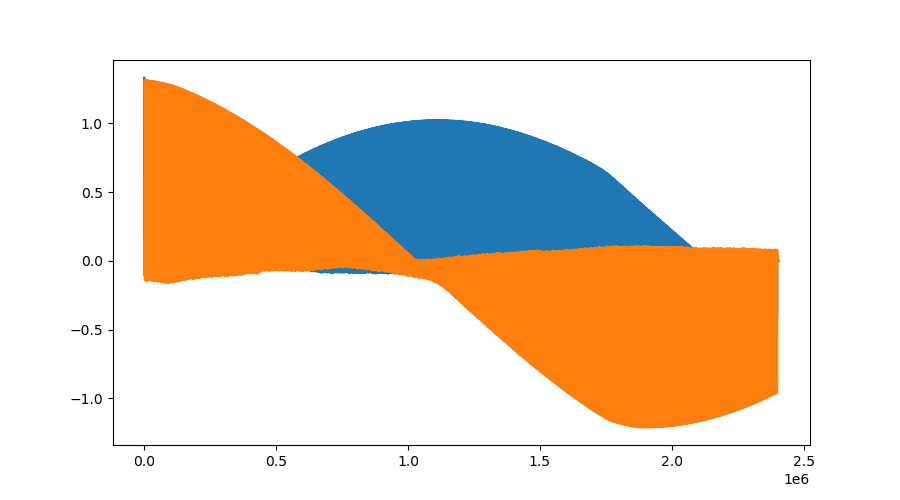

In [118]:
cfig = plt.figure(figsize=(9,5))
plt.plot(np.real(cp))
plt.plot(np.imag(cp))
plt.show()

In [1]:
#initialize a long run using CHRON
import numpy as np
import matplotlib.pyplot as pls

t2data = np.load('t2data.npy', allow_pickle=True)
t2times = np.load('t2times.npy', allow_pickle=True)

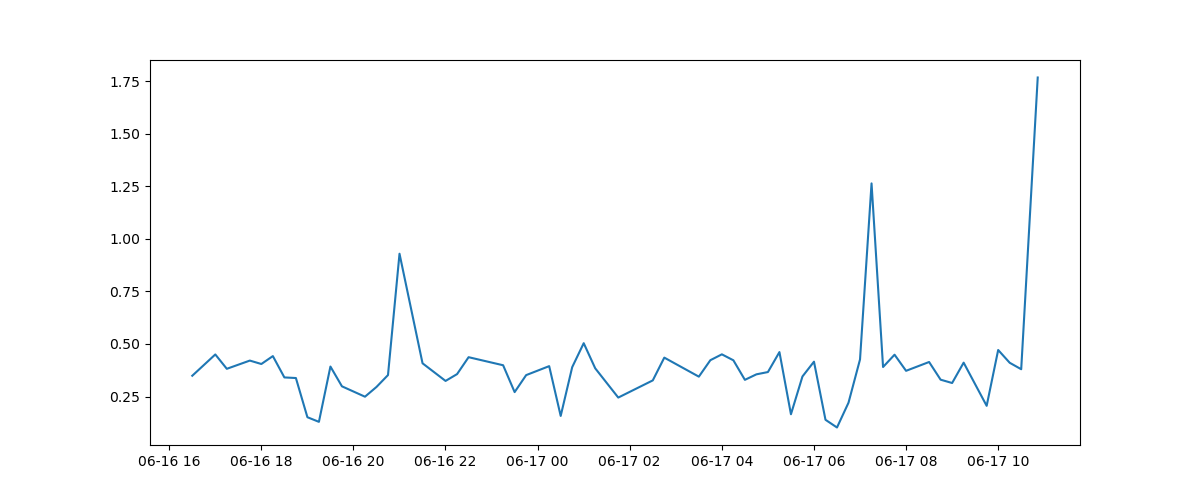

In [3]:
%matplotlib widget
ff = pls.figure(figsize = (12,5))
pls.plot(t2t_clean,t2d_clean)
pls.show()

In [2]:
t2d_clean = np.delete(t2data, t2data > 2)
t2t_clean = np.delete(t2times, t2data > 2)